# OCR 
- Tesseract Model:
training Google Tesseract pre-train model with 50 Vietnamese fonts
- Pre-processing:
using "imgtxtenh" library to preprocess an image. The function of 'imgtxtenh' is to clean/enhance noisy scanned text images.
- Image segmentation:
spliting an image into many rows of text. Inheriting the result of CRAFT model and G-DBSCAN(clustering algorithm)

# Pre-processing:
- Install imgtxtenh following this link: https://github.com/mauvilsa/imgtxtenh
- Run command: ./imgtxtenh -p [input_image]  [output_image]

# Image segmentation:

Notebook: from beginning to clustering stage

# Image to text:
Notebook: prediction stage


# Trình tự
- Tiền xử lý trên toàn bộ bức ảnh gốc với imgtxtenh để lọc nhiễu và background
- Khởi tạo thông số  cho craft model
- Dùng craft pretrain model dự đoán vị trí các từ trong ảnh sau khi lọc nhiễu, xoay ảnh nếu cần thiết
- Nhóm các từ theo hàng với G-DBSCAN(lưu ý 2 thông số xác định vùng lân cận của giải thuật)
- Bóc tách từng dữ liệu theo hàng, tiền xử lý đồng thời dùng tesseract model chuyển từng dòng ảnh sang chữ viết

Step-by-step:

###Step 1: Load image

###Step 2: Rotate image (or not)

###Step 3: Get the word bounding boxes

    • Input: Ảnh màu RGB, có width, height, channel

    • Output: Heat map và tọa độ bounding box của word

###Step 4: Lưu kết quả là hình ảnh đã có bounding box vào đường dẫn thư mục

###Step 5: Tính tọa độ của tâm các bounding box của word (Polys)

    • Input: Các Polys đã xác định được từ Step 4

    • Output: Tọa độ Central point của từng Polys

###Step 6: Chuyển mỗi tọa độ Central Point thành một Object Point, rồi đẩy vào mảng X

###Step 7: Reset lại 4 initial parameters của CRAFT (nếu  chạy nhiều ảnh)

###Step 8: DBScan từng Point trong Step 7 

  • Input: Các Polys đã xác định được từ Step 4

  • Output: Gom Point vào các Cluster (các word chung 1 hàng vào chung 1 cluster)

###Step 9: Với mỗi cluster tìm được trong Step 8, tạo 1 bounding box (Mỗi hàng text tạo 1 bounding box)

  • Output: list chứa các tọa độ của mỗi bounding box vừa tạo 
    (top_left, bottom_left, top_right,bottom_right)

###Step 10: Lưu kết quả là ảnh đã có bounding box vào đường dẫn thư mục

###Step 11: In ra nội dung text (dưới dạng chữ đánh máy) đã nhận diện được từ ảnh




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/My Drive/ocr_demo_code"

/content/drive/My Drive/ocr_demo_code


In [ ]:
import sys
import os
import time
import argparse

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from PIL import Image

import cv2
from skimage import io
import numpy as np
import craft_utils
import imgproc
import file_utils
import json
import zipfile

from craft import CRAFT
#OrderedDict: dictionary subclass that remembers the order that keys were first inserted
from collections import OrderedDict
import copy
import math

# CRAFT  

In [ ]:

def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")

In [ ]:
def test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net=None):
    t0 = time.time()
    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    # print("X: ",x)
  
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()
    # print("Score_text: ", score_text)
    # print("Score_link: ", score_link)

    # refine link
    if refine_net is not None:
        with torch.no_grad():
            y_refiner = refine_net(y, feature)
        score_link = y_refiner[0,:,:,0].cpu().data.numpy()
    t0 = time.time() - t0
    t1 = time.time()

    # Post-processing
    boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

    # coordinate adjustment
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]
    t1 = time.time() - t1

    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text = imgproc.cvt2HeatmapImg(render_img)
    # print("Render image: ", render_img)
    # plt.imshow(ret_score_text)
    # print("Bounding Box: ", polys)

    # if show_time : print("\ninfer/postproc time : {:.3f}/{:.3f}".format(t0, t1))

    return boxes, polys, ret_score_text

# G-DBSCAN

In [ ]:
class Point:
    '''
    Each point have 2 main values: coordinate(lat, long) and cluster_id
    '''
    def __init__(self, x, y, id):
        self.x = x
        self.y = y
        self.id = id
        self.cluster_id = UNCLASSIFIED

    def __repr__(self):
        return '(x:{}, y:{}, id:{}, cluster:{})' \
            .format(self.x, self.y, self.id, self.cluster_id)

#In G-DBScan we use elip instead of circle to cluster (because we mainly use for horizontal text image --> elip is more useful)
def n_pred(p1, p2):
#     return (p1.x - p2.x)**2/160000 + (p1.y - p2.y)**2/2500 <= 1
#     print(p1.x -p2.x)
#     print(p1.y -p2.y)
#     return (p1.x - p2.x)**2/50000 + (p1.y - p2.y)**2/1500 <= 1
#     return (p1.x - p2.x)**2/20000 + (p1.y - p2.y)**2/1300 <= 1
#     return (p1.x - p2.x)**2/2000 + (p1.y - p2.y)**2/130 <= 1
      return (p1.x - p2.x)**2/500 + (p1.y - p2.y)**2/70 <= 1
#     return (p1.x - p2.x)**2/3500 + (p1.y - p2.y)**2/150 <= 1
#     return (p1.x - p2.x)**2/7000 + (p1.y - p2.y)**2/1300 <= 1
#     return (p1.x - p2.x)**2/8000 + (p1.y - p2.y)**2/300 <= 1
#     return (p1.x - p2.x)**2/17000 + (p1.y - p2.y)**2/300 <= 1
#     return (p1.x - p2.x)**2/13000 + (p1.y - p2.y)**2/250 <= 1
#    return (p1.x - p2.x)**2/15000 + (p1.y - p2.y)**2/180 <= 1


def w_card(points):
    return len(points)

In [ ]:
UNCLASSIFIED = -2
NOISE = -1

def GDBSCAN(points, n_pred, min_card, w_card):
    points = copy.deepcopy(points)
    cluster_id = 0
    for point in points:
        if point.cluster_id == UNCLASSIFIED:
            if _expand_cluster(points, point, cluster_id, n_pred, min_card,
                               w_card):
                cluster_id = cluster_id + 1
    clusters = {}
    for point in points:
        key = point.cluster_id
        if key in clusters:
            clusters[key].append(point)
        else:
            clusters[key] = [point]
    return list(clusters.values())


def _expand_cluster(points, point, cluster_id, n_pred, min_card, w_card):
    if not _in_selection(w_card, point):
        points.change_cluster_id(point, UNCLASSIFIED)
        return False

    seeds = points.neighborhood(point, n_pred)
    if not _core_point(w_card, min_card, seeds):
        points.change_cluster_id(point, NOISE)
        return False

    points.change_cluster_ids(seeds, cluster_id)
    seeds.remove(point)

    while len(seeds) > 0:
        current_point = seeds[0]
        result = points.neighborhood(current_point, n_pred)
        if w_card(result) >= min_card:
            for p in result:
                if w_card([p]) > 0 and p.cluster_id in [UNCLASSIFIED, NOISE]:
                    if p.cluster_id == UNCLASSIFIED:
                        seeds.append(p)
                    points.change_cluster_id(p, cluster_id)
        seeds.remove(current_point)
    return True


def _in_selection(w_card, point):
    return w_card([point]) > 0


def _core_point(w_card, min_card, points):
    return w_card(points) >= min_card


class Points:
    'Contain list of Point'
    def __init__(self, points):
        self.points = points

    def __iter__(self):
        for point in self.points:
            yield point

    def __repr__(self):
        return str(self.points)

    def get(self, index):
        return self.points[index]

    def neighborhood(self, point, n_pred):
        return list(filter(lambda x: n_pred(point, x), self.points))

    def change_cluster_ids(self, points, value):
        for point in points:
            self.change_cluster_id(point, value)

    def change_cluster_id(self, point, value):
        index = (self.points).index(point)
        self.points[index].cluster_id = value

    def labels(self):
        return set(map(lambda x: x.cluster_id, self.points))

# Word detection

In [ ]:
# Initialize CRAFT parameters
text_threshold = 0.7
low_text = 0.4
link_threshold =0.4
# cuda = True
cuda=False
canvas_size =1280
mag_ratio =1.5
#if text image present curve --> poly=true
poly=False
refine=False
show_time=False
refine_net = None
#path of file pre-trained model of Craft
trained_model_path = './craft_mlt_25k.pth'
#trained_model_path = './vgg16.ckpt'

Load CRAFT pre-train model

Load data and apply CRAFT model to recognize word blocks on an image

Link github of Craft Model: https://github.com/clovaai/CRAFT-pytorch
(Paper of Craft model we used also in this git link)

In [ ]:
net = CRAFT()
net.load_state_dict(copyStateDict(torch.load(trained_model_path, map_location='cpu')))
net.eval()

CRAFT(
  (basenet): vgg16_bn(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (slice2): Sequential(
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kerne

In [ ]:
# Load image from its path
image_path = './imgtxtenh/pre_test10.jpg'
image = imgproc.loadImage(image_path)

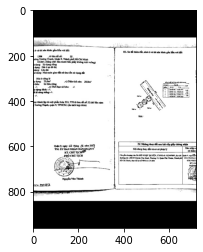

In [ ]:
# If you need rotate an image, use imutils library and call rotate method with specified number of angle  degrees about the center of the image
#In this case we don't need to rotate --> Just skip this step
import imutils
%matplotlib inline
import matplotlib.pyplot as plt

image = imutils.rotate(image, 90)
plt.imshow(image)
plt.show()

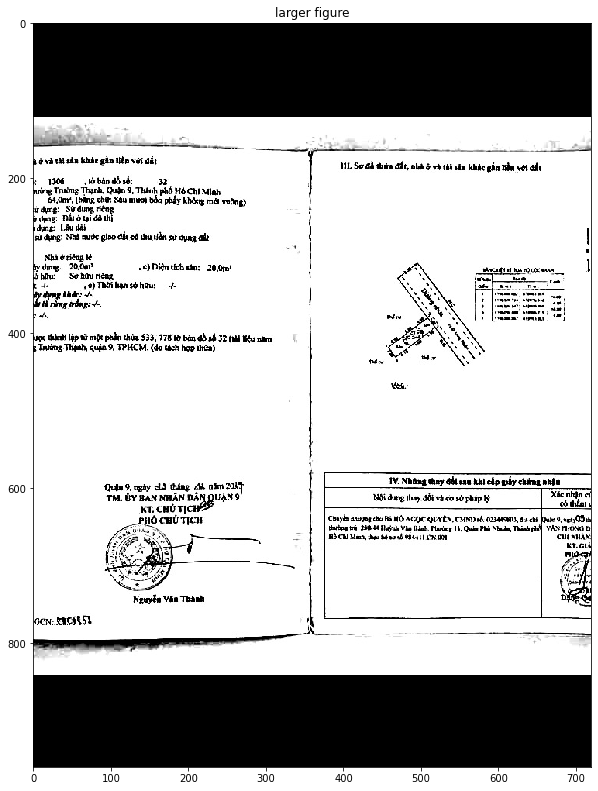

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig2 = plt.figure(figsize = (10,40)) # create a 10 x 10 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(image, interpolation='none')
ax3.set_title('larger figure')

plt.show()

In [ ]:
# Apply predict function to the image then get the word bounding boxes
#Use result of pre-trained Craft model to detect word in image by create bounding box for each word
bboxes, polys, score_text = test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net)


In [ ]:
# Save results of CRAFT model prediction to the directory 
file_utils.saveResult(image_path, image[:,:,::-1], bboxes, dirname='./craft_result/')

In [ ]:
# Compute coordinate of central point in each bounding box returned by CRAFT
#Purpose: easier for us to make cluster in G-DBScan step
poly_indexes = {}
central_poly_indexes = []
for i in range(len(polys)):
  poly_indexes[i] =  polys[i]
  x_central = (polys[i][0][0] + polys[i][1][0] +polys[i][2][0] + polys[i][3][0])/4
  y_central = (polys[i][0][1] + polys[i][1][1] +polys[i][2][1] + polys[i][3][1])/4
  central_poly_indexes.append({i: [int(x_central), int(y_central)]})

for i in central_poly_indexes:
  print(i)

{0: [94, 177]}
{1: [114, 176]}
{2: [144, 177]}
{3: [44, 177]}
{4: [72, 177]}
{5: [14, 179]}
{6: [426, 183]}
{7: [475, 184]}
{8: [404, 184]}
{9: [453, 184]}
{10: [522, 185]}
{11: [594, 186]}
{12: [630, 186]}
{13: [572, 186]}
{14: [107, 201]}
{15: [90, 203]}
{16: [122, 203]}
{17: [30, 204]}
{18: [76, 204]}
{19: [168, 205]}
{20: [77, 216]}
{21: [171, 216]}
{22: [189, 215]}
{23: [43, 217]}
{24: [107, 216]}
{25: [124, 216]}
{26: [146, 216]}
{27: [207, 217]}
{28: [13, 218]}
{29: [229, 217]}
{30: [158, 227]}
{31: [35, 228]}
{32: [67, 229]}
{33: [92, 228]}
{34: [114, 228]}
{35: [136, 228]}
{36: [180, 228]}
{37: [208, 230]}
{38: [232, 231]}
{39: [259, 232]}
{40: [21, 241]}
{41: [48, 240]}
{42: [68, 241]}
{43: [93, 241]}
{44: [4, 241]}
{45: [83, 251]}
{46: [46, 252]}
{47: [66, 252]}
{48: [96, 252]}
{49: [3, 253]}
{50: [20, 254]}
{51: [44, 264]}
{52: [61, 264]}
{53: [15, 266]}
{54: [122, 275]}
{55: [163, 275]}
{56: [26, 277]}
{57: [51, 276]}
{58: [75, 276]}
{59: [97, 277]}
{60: [146, 276]}
{61: [

In [ ]:
# For each of these cordinates convert them to new Point instances
X = []

for idx, x in enumerate(central_poly_indexes):
    point = Point(x[idx][0],x[idx][1], idx)
    X.append(point)

In [ ]:
# Reset CRAFT 4 initial parameters
# Use it in case you want to run more than 1 image 
poly=False
refine=False
show_time=False
refine_net = None

# Clustering stage:

This part focuses to cluster these central points having from your CRAFT boxes to many group called text blocks. 

In [ ]:
# Cluster these central points
clustered = GDBSCAN(Points(X), n_pred, 1, w_card)
for i in clustered:
  print(i)

[(x:94, y:177, id:0, cluster:0), (x:114, y:176, id:1, cluster:0), (x:72, y:177, id:4, cluster:0)]
[(x:144, y:177, id:2, cluster:1)]
[(x:44, y:177, id:3, cluster:2)]
[(x:14, y:179, id:5, cluster:3)]
[(x:426, y:183, id:6, cluster:4), (x:404, y:184, id:8, cluster:4)]
[(x:475, y:184, id:7, cluster:5), (x:453, y:184, id:9, cluster:5)]
[(x:522, y:185, id:10, cluster:6)]
[(x:594, y:186, id:11, cluster:7), (x:572, y:186, id:13, cluster:7)]
[(x:630, y:186, id:12, cluster:8)]
[(x:107, y:201, id:14, cluster:9), (x:90, y:203, id:15, cluster:9), (x:122, y:203, id:16, cluster:9), (x:76, y:204, id:18, cluster:9)]
[(x:30, y:204, id:17, cluster:10)]
[(x:168, y:205, id:19, cluster:11)]
[(x:77, y:216, id:20, cluster:12)]
[(x:171, y:216, id:21, cluster:13), (x:189, y:215, id:22, cluster:13), (x:207, y:217, id:27, cluster:13), (x:229, y:217, id:29, cluster:13)]
[(x:43, y:217, id:23, cluster:14)]
[(x:107, y:216, id:24, cluster:15), (x:124, y:216, id:25, cluster:15), (x:146, y:216, id:26, cluster:15)]
[(x:13

In [ ]:
# Create bounding box for each cluster with 4 points
#Purpose: Merge words in 1 cluster into 1 bounding box
cluster_values = []
for cluster in clustered:
    sort_cluster = sorted(cluster, key = lambda elem: (elem.x, elem.y))
    max_point_id = sort_cluster[len(sort_cluster) - 1].id
    min_point_id = sort_cluster[0].id
    max_rectangle = sorted(poly_indexes[max_point_id], key = lambda elem: (elem[0], elem[1]))
    min_rectangle = sorted(poly_indexes[min_point_id], key = lambda elem: (elem[0], elem[1]))

    right_above_max_vertex = max_rectangle[len(max_rectangle) -1]
    right_below_max_vertex = max_rectangle[len(max_rectangle) -2]
    left_above_min_vertex = min_rectangle[0] 
    left_below_min_vertex = min_rectangle[1]
    
    if (int(min_rectangle[0][1]) > int(min_rectangle[1][1])): 
        left_above_min_vertex = min_rectangle[1]
        left_below_min_vertex =  min_rectangle[0]
    if (int(max_rectangle[len(max_rectangle) -1][1]) < int(max_rectangle[len(max_rectangle) -2][1])):
        right_above_max_vertex = max_rectangle[len(max_rectangle) -2]
        right_below_max_vertex = max_rectangle[len(max_rectangle) -1]
        
        
    cluster_values.append([left_above_min_vertex, left_below_min_vertex, right_above_max_vertex, right_below_max_vertex])
    
    for p in cluster_values:
      print(p)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[array([  0., 213.], dtype=float32), array([  0. , 223.5], dtype=float32), array([ 27. , 223.5], dtype=float32), array([ 27., 213.], dtype=float32)]
[array([ 82.5, 223.5], dtype=float32), array([ 82.5, 234. ], dtype=float32), array([192. , 235.5], dtype=float32), array([192., 222.], dtype=float32)]
[array([ 19.5, 223.5], dtype=float32), array([ 19.5, 234. ], dtype=float32), array([ 51., 234.], dtype=float32), array([ 51. , 223.5], dtype=float32)]
[array([ 54.202938, 222.36176 ], dtype=float32), array([ 53.320587, 233.83234 ], dtype=float32), array([ 80.850006, 235.95001 ], dtype=float32), array([ 81.73235, 224.4794 ], dtype=float32)]
[array([193.59137, 223.72083], dtype=float32), array([192.7614, 235.3401], dtype=float32), array([223.3553 , 237.52538], dtype=float32), array([224.18527, 225.9061 ], dtype=float32)]
[array([223.5, 226.5], dtype=float32), array([223.5, 235.5], dtype=float32), array([241.5, 235.5], dtype=float32), arr

In [ ]:
# Save results of clustering stage to the directory 
file_utils.saveResult(image_path, image[:,:,::-1], cluster_values, dirname='./cluster_result/')

# Prediction stage
Use tesseract model to convert these segments of an image to text


In [ ]:
!pip3 install pytesseract

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import pytesseract    

In [ ]:
def img_to_text(image):
  # Initialize CRAFT parameters
  text_threshold = 0.7
  low_text = 0.4
  link_threshold =0.4
  cuda=False
  canvas_size =1280
  mag_ratio =1.5
  poly=False
  refine=False
  show_time=False
  refine_net = None
  trained_model_path = './craft_mlt_25k.pth'

  bboxes, polys, score_text = test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net)

  file_utils.saveResult(image_path, image[:,:,::-1], bboxes, dirname='./craft_result/')

  poly_indexes = {}
  central_poly_indexes = []
  for i in range(len(polys)):
    poly_indexes[i] =  polys[i]
    x_central = (polys[i][0][0] + polys[i][1][0] +polys[i][2][0] + polys[i][3][0])/4
    y_central = (polys[i][0][1] + polys[i][1][1] +polys[i][2][1] + polys[i][3][1])/4
    central_poly_indexes.append({i: [int(x_central), int(y_central)]})

  X = []
  for idx, x in enumerate(central_poly_indexes):
    point = Point(x[idx][0],x[idx][1], idx)
    X.append(point)

  poly=False
  refine=False
  show_time=False
  refine_net = None
  
  clustered = GDBSCAN(Points(X), n_pred, 1, w_card)

  cluster_values = []
  for cluster in clustered:
    sort_cluster = sorted(cluster, key = lambda elem: (elem.x, elem.y))
    max_point_id = sort_cluster[len(sort_cluster) - 1].id
    min_point_id = sort_cluster[0].id
    max_rectangle = sorted(poly_indexes[max_point_id], key = lambda elem: (elem[0], elem[1]))
    min_rectangle = sorted(poly_indexes[min_point_id], key = lambda elem: (elem[0], elem[1]))

    right_above_max_vertex = max_rectangle[len(max_rectangle) -1]
    right_below_max_vertex = max_rectangle[len(max_rectangle) -2]
    left_above_min_vertex = min_rectangle[0] 
    left_below_min_vertex = min_rectangle[1]
    
    if (int(min_rectangle[0][1]) > int(min_rectangle[1][1])): 
        left_above_min_vertex = min_rectangle[1]
        left_below_min_vertex =  min_rectangle[0]
    if (int(max_rectangle[len(max_rectangle) -1][1]) < int(max_rectangle[len(max_rectangle) -2][1])):
        right_above_max_vertex = max_rectangle[len(max_rectangle) -2]
        right_below_max_vertex = max_rectangle[len(max_rectangle) -1]
            
    cluster_values.append([left_above_min_vertex, left_below_min_vertex, right_above_max_vertex, right_below_max_vertex])

  file_utils.saveResult(image_path, image[:,:,::-1], cluster_values, dirname='./cluster_result/')

  img = np.array(image[:,:,::-1])

  res = []
  for i, box in enumerate(cluster_values):
    poly = np.array(box).astype(np.int32).reshape((-1))
    poly = poly.reshape(-1, 2)

    rect = cv2.boundingRect(poly)
    x,y,w,h = rect
    croped = img[y:y+h, x:x+w].copy()
  
    # Preprocess croped segment
    croped = cv2.resize(croped, None, fx=5, fy=5, interpolation=cv2.INTER_LINEAR)
    croped = cv2.cvtColor(croped, cv2.COLOR_BGR2GRAY)
    croped = cv2.GaussianBlur(croped, (3, 3), 0)
    croped = cv2.bilateralFilter(croped,5,25,25)
    croped = cv2.dilate(croped, None, iterations=1)
    croped = cv2.threshold(croped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    # croped = cv2.threshold(croped, 90, 255, cv2.THRESH_BINARY)[1]
    croped = cv2.cvtColor(croped, cv2.COLOR_BGR2RGB)

    text = pytesseract.image_to_string(croped, lang='eng')
    res.append(text)
  return res

In [ ]:
def X_Y_localization(listText):
  new_text = []
  res1 = []
  res2 = []
  count = {}
  for text in listText:
    # obmit space and endl in text
    text_without_space_endl = ''
    for word in text.split():
      text_without_space_endl += word
    
    if len(text_without_space_endl) < 4 or len(text_without_space_endl) > 11:
      continue
    # modify some easy to misunderstanding features in the text
    norm_text = ''
    for i in range(len(text_without_space_endl)):
        if text_without_space_endl[i] in ['S','$']:
          norm_text += '5'
        else:
          norm_text += text_without_space_endl[i]
    new_text.append(norm_text)
    # Check the frequency of first 4 letters in norm_text
    first_4 = norm_text[0:4]  
    if first_4 in count:
      count[first_4] += 1
    else:
      count[first_4] = 1  
  max = 0
  str1 = ''
  for i in count:
    if count[i] > max:
      max = count[i]
      str1 = i
  max = 0
  str2 = ''
  for i in count:
    if i != str1 and count[i] > max:
      max = count[i]
      str2 = i
  if not str1.isdigit() or not str2.isdigit():  # 4 so dau tien cuc ki quan trong, neu k xac dinh chinh xac 1 trong 2 thi xem nhu khong tim dc
    return res1, res2   # res1 = res2 = [] 
  avg_len1 = 0
  avg_len2 = 0
  for text in new_text:
    if text[0:4] == str1:
      res1.append(text)
      if '.' in text:
        avg_len1 += len(text)
      else:
        avg_len1 += len(text) + 1
    elif text[0:4] == str2:
      res2.append(text)
      if '.' in text:
        avg_len2 += len(text)
      else:
        avg_len2 += len(text) + 1
  avg_len1 = avg_len1 / len(res1)
  avg_len2 = avg_len2 / len(res2)
  if avg_len1 > avg_len2:
    return res1, res2
  else:
    return res2, res1

In [ ]:
def norm_X_Y(listX, listY):
  if listX == [] or listY == []:
    print('Cannot read X,Y from img')
    return [],[]
  float_listX = []
  float_listY = []
  for text in listX:
    if len(text) < 7:
      continue
    norm_text = ''
    if text.count('.') > 1 or ('.' in text and text.index('.') != 7):
      # neu xhien >1 '.' or dau '.' nam sai vi tri (sau chu so thu 7) thi bo toan bo '.' roi them lai sau
      for letter in text:
        if letter != '.':
          norm_text += letter
      text = norm_text
      norm_text = ''
    for i in range(len(text)):
      if text[i] == ',':
        norm_text += '.'
      elif text[i] != '.' and not text[i].isdigit():
        norm_text += '5'  # Vi cac so sau sai lech khong anh huong qua lon den toa do nen chuan hoa cac ki tu k phai so thanh 5
      else:
        norm_text += text[i]
    # Xu ly cac truong hop khong co '.'
    if norm_text.count('.') == 0:
      text = ''
      for i in range(len(norm_text)):
        if i == 6:
          text += norm_text[i] + '.'
        else:
          text += norm_text[i]
    else:
      text = norm_text
    float_listX.append(float(text))
  
  for text in listY:
    if len(text) < 6:
      continue
    norm_text = ''
    if text.count('.') > 1 or ('.' in text and text.index('.') != 6): 
      # neu xhien >1 '.' or dau '.' nam sai vi tri (sau chu so thu 6) thi bo toan bo '.' roi them lai sau
      for letter in text:
        if letter != '.':
          norm_text += letter
      text = norm_text
      norm_text = ''
    for i in range(len(text)):
      if text[i] == ',':
        norm_text += '.'
      elif text[i] != '.' and not text[i].isdigit():
        norm_text += '5'  # Vi cac so sau sai lech khong anh huong qua lon den toa do nen chuan hoa cac ki tu k phai so thanh 5
      else:
        norm_text += text[i]
    # Xu ly cac truong hop khong co '.'
    if norm_text.count('.') == 0:
      text = ''
      for i in range(len(norm_text)):
        if i == 5:
          text += norm_text[i] + '.'
        else:
          text += norm_text[i]
    else:
      text = norm_text
    float_listY.append(float(text))
  return float_listX, float_listY

In [ ]:
def get_X_Y (X,Y):
  res_x = 0
  res_y = 0
  if X == [] or Y == []:
    print('Cannot get X,Y. Try another img')
    return res_x, res_y
  found_x = 0
  found_y = 0
  for x in X:
    for another_x in X:
      if abs(another_x - x) > 0 and abs(another_x - x) < 10:
        found_x += 1
        res_x = (another_x + x) / 2
        break
    if found_x > 0:
      break

  for y in Y:
    for another_y in Y:
      if abs(another_y - y) > 0 and abs(another_y - y) < 10:
        found_y += 1
        res_y = (another_y + y) / 2
        break
    if found_y > 0:
      break
    
  if found_x == 0: # lay trung binh cong
    for x in X:
      res_x += x
    res_x = res_x / len(X)
  if found_y == 0: # lay trung binh cong
    for y in Y:
      res_y += y
    res_y = res_y / len(Y)
  return res_x, res_y

# First test:

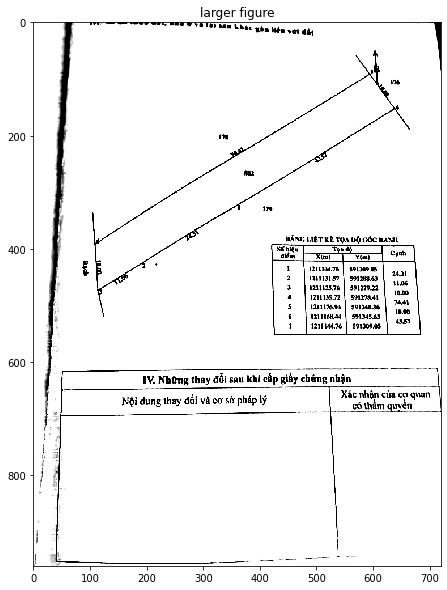

In [ ]:
image_path = './imgtxtenh/pre_test4.jpg'
image = imgproc.loadImage(image_path)
fig2 = plt.figure(figsize = (10,10)) # create a 10 x 10 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(image, interpolation='none')
ax3.set_title('larger figure')

plt.show()

In [ ]:
listText = img_to_text(image)
print(listText)

['\x0c', 'be be ae\n\x0c', '\x0c', '\x0c', '\x0c', 'Gay\n\x0c', '\x0c', 'BANG\n\x0c', 'LAeT\n\x0c', 'KP.\n\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '¥(m)\n\x0c', '\x0c', 'b201144.76\n\x0c', '$91 309.05\n\x0c', '\x0c', '1249031.57\n\x0c', 'S91288.63\n\x0c', '\x0c', '1210125.76\n\x0c', '§91279.22\n\x0c', '\x0c', '1290138.72\n\x0c', 'S9ITTRAI\n\x0c', '\x0c', '1211176.908\n\x0c', '$91340.3%6\n\x0c', '\x0c', 'Q21!\n\x0c', '\x0c', '$91348.45\n\x0c', '\x0c', '1211 1444.76\n\x0c', '$91309.05\n\x0c', 'tiy\n\x0c', 'ciip\n\x0c', 'gify\n\x0c', '\x0c', 'chirng\n\x0c', '\x0c', 'Nhdng\n\x0c', 'thay\n\x0c', '\x0c', 'Sau\n\x0c', 'Xac\n\x0c', 'nhan\n\x0c', 'cua\n\x0c', '\x0c', 'quan\n\x0c', 'ddi\n\x0c', 'va\n\x0c', '\x0c', 'phap\n\x0c', '\x0c', 'N6i\n\x0c', 'dung\n\x0c', 'thay\n\x0c', 'CO\n\x0c', 'tham\n\x0c', 'quyén\n\x0c', 'cé\n\x0c']


In [ ]:
listX, listY = X_Y_localization(listText)
print(listX, listY)

['1211176.908', '12111444.76'] ['591309.05', '591340.3%6', '591348.45', '591309.05']


In [ ]:
X,Y = norm_X_Y(listX,listY)
print(X,Y)

[1211176.908, 1211144.476] [591309.05, 591340.356, 591348.45, 591309.05]


In [ ]:
print(get_X_Y(X,Y))

(1211160.692, 591344.4029999999)


# Second test

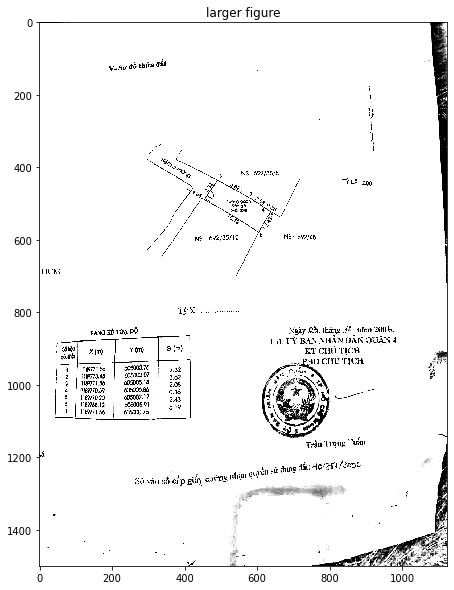

In [ ]:
image_path = './imgtxtenh/pre_test5.jpg'
image = imgproc.loadImage(image_path)
fig2 = plt.figure(figsize = (10,10)) # create a 10 x 10 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(image, interpolation='none')
ax3.set_title('larger figure')

plt.show()

In [ ]:
listText = img_to_text(image)
print(listText)

['dat\n\x0c', '\x0c', 'thira\n\x0c', '\x0c', 'So’\n\x0c', '\x0c', '\x0c', 'NS\n\x0c', '6972/35/83\n\x0c', '\x0c', '200\n\x0c', '\x0c', 'Os\n\x0c', '\x0c', '\x0c', '\x0c', '\x0c', 'S4n\n\x0c', 'VS\n\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '692/48\n\x0c', '692 /35/12\n\x0c', '\x0c', 'LIChs\n\x0c', '\x0c', 'Ay.\n\x0c', '2004\n\x0c', '\x0c', 'pease.\n\x0c', '\x0c', 'Ngay\n\x0c', 'thang\n\x0c', 'nam\n\x0c', '\x0c', '\x0c', 'BANG\n\x0c', 'DAIN\n\x0c', '\x0c', 'QUAN 4\n\x0c', 'UY\n\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', 'TICH\n\x0c', '\x0c', 'gbc this\n\x0c', 'CHU\n\x0c', 'PHO\n\x0c', 'TiC\n\x0c', '605000. 76\n\x0c', '1189771.\n\x0c', '\x0c', '2.32\n\x0c', '605002.07\n\x0c', '1189773.\n\x0c', '\x0c', '3.62\n\x0c', '\x0c', '\x0c', '118977\n\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '1189770.39\n\x0c', '0.36\n\x0c', '605007.17\n\x0c', 'I\n\n89770.\n\x0c', '\x0c', '2,43\n\x0c', '1189768.\n\x0c', '\x0c', '605005.9 1]\n\x0c', '6.19\n\x0c', '118977 1.56\n\x0c', '605000.76\n

In [ ]:
listX, listY = X_Y_localization(listText)
print(listX, listY)

['605000.76', '605002.07', '605007.17', '605005.91]', '605000.76'] ['1189771.', '1189773.', '118977', '1189770.39', '1189768.', '1189771.56']


In [ ]:
X,Y = norm_X_Y(listX,listY)
print(X,Y)

[6050007.6, 6050020.7, 6050071.7, 6050059.15, 6050007.6] [118977.1, 118977.3, 118977.0, 118977.039, 118976.8, 118977.156]


In [ ]:
print(get_X_Y(X,Y))

(6050033.35, 118977.20000000001)


# Third test

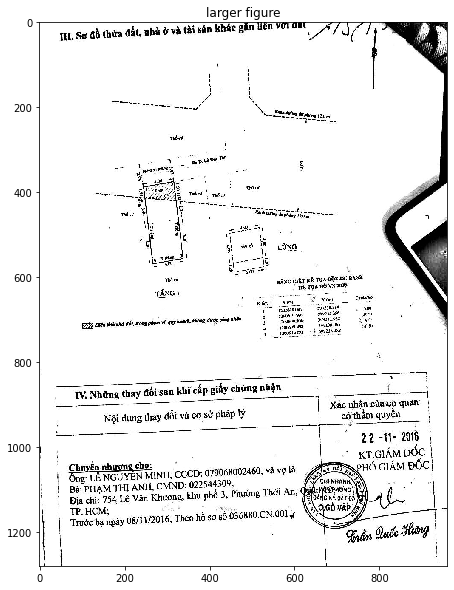

In [ ]:
image_path = './imgtxtenh/pre_test6.jpg'
image = imgproc.loadImage(image_path)
fig2 = plt.figure(figsize = (10,10)) # create a 10 x 10 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(image, interpolation='none')
ax3.set_title('larger figure')

plt.show()

In [ ]:
listText = img_to_text(image)
print(listText)

['én\n\x0c', 'vGl\n\x0c', 'Oat\n\x0c', 'gin\n\x0c', 'khac\n\x0c', 'san\n\x0c', 'tai\n\x0c', 'dat,\n\x0c', '6 va\n\x0c', 'nha\n\x0c', 'dé\n\x0c', 'thira\n\x0c', 'Ith.\n\x0c', '\x0c', '\x0c', '\x0c', '(2 ten\n\x0c', '\x0c', 'Thd ov\n\x0c', '\x0c', 'Le Ot\n\x0c', 'Re BD.\n\x0c', 'ming\n\x0c', 'vem\n\x0c', '\x0c', '\x0c', 'Tre) cv\n\x0c', 'Ranh\n\x0c', '\x0c', 'Ted ot\n\x0c', 'if pining\n\x0c', 'J20m\n\x0c', 'an gv\n\x0c', '\x0c', '\x0c', 'RANA\n\x0c', 'KE\n\x0c', '\x0c', '\x0c', '\x0c', 'VN -2000-\n\x0c', 'BO\n\x0c', 'HE\n\x0c', 'TOA\n\x0c', 'TANG.\n\x0c', '\x0c', '\x0c', '\x0c', '\x0c', 'SofT2IN_IMK\n\x0c', '1200679.0084\n\x0c', '$992.42. 354\n\x0c', '920008 19 5\n\x0c', 'dirgc cing nhda\n\x0c', 'guy b2se\n\x0c', '\x0c', '\x0c', 'Hn\n\x0c', '1200069.\n\x0c', 'Dign tich aha 48¢,\n\x0c', '\x0c', '\x0c', '\x0c', 'G72 JAAD\n\x0c', '54a. fl\n\x0c', '120M rT SS\n\x0c', '$992 5%. JAE\n\x0c', '1200619\n\x0c', '\x0c', 'nhan\n\x0c', 'giay\n\x0c', 'chimg\n\x0c', 'A\ncap\n\x0c', 'adi\n\x0c', '\x0c',

In [ ]:
listX, listY = X_Y_localization(listText)
print(listX, listY)

['5992.42.354', '59925%.JAE'] ['1200069.', '1200619']


In [ ]:
X,Y = norm_X_Y(listX,listY)
print(X,Y)

[5992423.54, 5992555.55] [120006.9, 120061.9]


In [ ]:
print(get_X_Y(X,Y))

(5992489.545, 120034.4)


# Fourth test

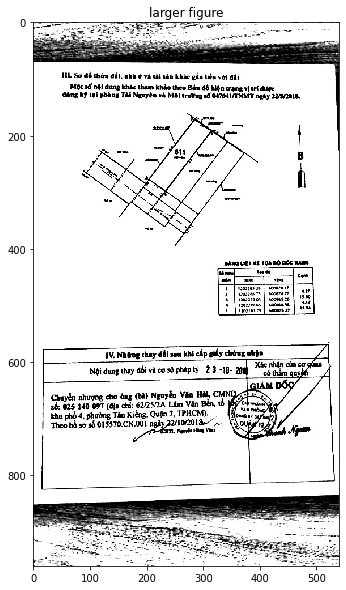

In [ ]:
image_path = './imgtxtenh/pre_test7.jpg'
image = imgproc.loadImage(image_path)
fig2 = plt.figure(figsize = (10,10)) # create a 10 x 10 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(image, interpolation='none')
ax3.set_title('larger figure')

plt.show()

In [ ]:
listText = img_to_text(image)
print(listText)

['111. So a4\n\x0c', 'ade,\n\x0c', '\x0c', 'nha\n\x0c', '6 va tai\n\x0c', 's28\n\x0c', 'khac\n\x0c', 'gain li¢e\n\x0c', '\x0c', 'Mot so\n\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', 'vi irt didge\n\x0c', 'trang\n\x0c', 'Ging kf tai\n\x0c', 'Tal\n\x0c', '\x0c', '\x0c', 'va Ml\n\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', 'Aa LAPT KE TOA\n\x0c', '\x0c', 'O06 RAMH\n\x0c', 'e207 720)\n\x0c', '\x0c', 'BOTTI\n\x0c', '1302)\n\x0c', '\x0c', 'khi cip\n\x0c', 'giky\n\x0c', 'at\n\x0c', 'chdéug\n\x0c', '\x0c', 'Nh@ug\n\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '23 -16-\n\x0c', '\x0c', 'va co 30\n\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', 'Nguyts\n\x0c', 'Via\n\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', 'Vin\n\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '\x0c', 'TPHCM\n\n).\n\x0c', 'Kiéng.\n\x0c', '\x0c', '\x0c', '\x0c', 'Tan\n\x0c', '\x0c', '\x0c', '22/10/201%&\n\x0c', '

In [ ]:
listX, listY = X_Y_localization(listText)
print(listX, listY)

[] []


In [ ]:
X,Y = norm_X_Y(listX,listY)
print(X,Y)

Cannot read X,Y from img
[] []


In [ ]:
print(get_X_Y(X,Y))

Cannot get X,Y. Try another img
(0, 0)


# Fifth test

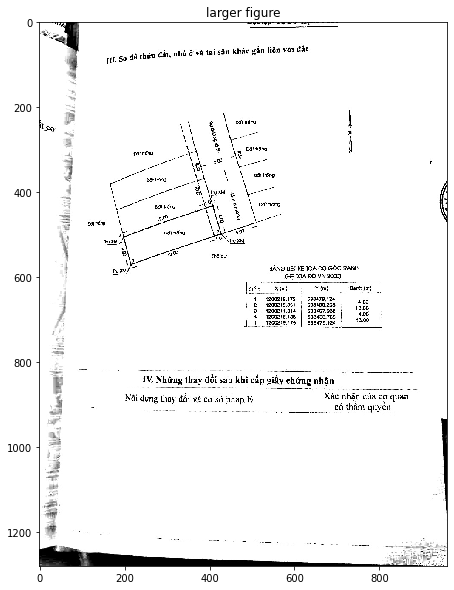

In [ ]:
image_path = './imgtxtenh/pre_test8.jpg'
image = imgproc.loadImage(image_path)
fig2 = plt.figure(figsize = (10,10)) # create a 10 x 10 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(image, interpolation='none')
ax3.set_title('larger figure')

plt.show()

In [ ]:
listText = img_to_text(image)
print(listText)

['dat\n\x0c', 'gan\n\x0c', 'lién\n\x0c', 'vol\n\x0c', 'khac\n\x0c', 'lal\n\x0c', '\x0c', 'dat,\n\x0c', '\x0c', '\x0c', '\x0c', '(hira\n\x0c', 'So\n\x0c', 'jar.\n\x0c', 'org\n\x0c', 'Aut 7\n\x0c', '\x0c', 'ao on\n\x0c', '\x0c', 'wae\n\x0c', '\x0c', 'Kony\n\x0c', '\x0c', '\x0c', '\x0c', '6\n\x0c', 'rong\n\x0c', '\x0c', 'trong\n\x0c', '\x0c', '\x0c', 'wy\n\x0c', 'Do\n\x0c', 'trong\n\x0c', '\x0c', 'rang\n\x0c', 'po!\n\x0c', '\x0c', 'OS} PENG\n\x0c', 'oh\n\x0c', 'tng\n\x0c', 'Oo\n\x0c', '\x0c', 'ThS CU\n\x0c', '\x0c', 'BANG\n\x0c', 'uf KE\n\x0c', 'RANH\n\x0c', 'TOA\n\x0c', '\x0c', 'WA\n\x0c', '\x0c', 'VN\n\x0c', '\x0c', 'Biém\n\x0c', '\x0c', '(a))\n\x0c', 'Cann\n\x0c', '(7)\n\x0c', '1200215.175\n\x0c', '598478 124\n\x0c', '4.00\n\x0c', '1200215.35t\n\x0c', '5984 80.298\n\x0c', '13.00\n\x0c', '120021\n\x0c', '314\n\x0c', '596467 938\n\x0c', '4.0\n\x0c', '1200215.\n\x0c', '\x0c', '\x0c', '13.00\n\x0c', '\x0c', '\x0c', '$98479.124\n\x0c', 'Ol\n\x0c', 'cap\n\x0c', 'giay\n\x0c', '\x0c', 'Nhimng\

In [ ]:
listX, listY = X_Y_localization(listText)
print(listX, listY)

['598478124', '598480.298', '598479.124'] ['1200215.175', '1200215.35t', '120021', '1200215.']


In [ ]:
X,Y = norm_X_Y(listX,listY)
print(X,Y)

[5984781.24, 5984802.98, 5984791.24] [120021.5175, 120021.5355, 120021.0, 120021.5]


In [ ]:
print(get_X_Y(X,Y))

(5984791.82, 120021.5265)


# Sixth test

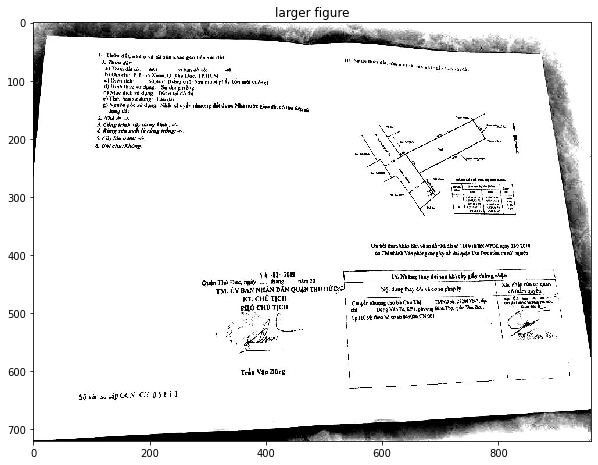

In [ ]:
image_path = './imgtxtenh/pre_test9.jpg'
image = imgproc.loadImage(image_path)
fig2 = plt.figure(figsize = (10,10)) # create a 10 x 10 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(image, interpolation='none')
ax3.set_title('larger figure')

plt.show()

In [ ]:
listText = img_to_text(image)
print(listText)

['Tages dht. nbaasa\n\x0c', 'hae gin lide vai ddt\n\x0c', 'Cetsan\n\x0c', 'S47 84 thumy Ube, Wha vive\n\x0c', 'There de,\n\x0c', 'cha lin wh Ght\n\x0c', '8) linn\n\x0c', 'ASt a0\n\x0c', '\x0c', 'to Ban db od\n\x0c', '\x0c', 'B) Diachs I Pink Nain. Q. Chi Dd.\n\x0c', 'TPHICM\n\x0c', 'CP Ede tich\n\x0c', 'phsy bin met\n\x0c', "OV.en0'\n\x0c", '{hang ono Nau mudi\n\x0c', 'ving)\n\x0c', 'O} Hlinh thue so dung\n\x0c', 'Su dung\n\x0c', 'NEN\n\x0c', 'OF} Mywe dich ut dung\n\noe rr re\n\x0c', 'Dat & tat dé thi\n\x0c', 'ep ena - Arg:\nep e 1 Fiaue sur Poe\n\x0c', 'Usu da\n\x0c', 'Neuse gic si dung.\n\x0c', 'Nhdn chuvén\n\x0c', 'dds Juve Nie ste\n\x0c', 'nhuyng\n\x0c', 'gaan obi\n\x0c', 'CO UW tide ge,\n\x0c', 'duny dat\n\x0c', '\x0c', 'thdc. ~\n_\n\x0c', 'Cang\n\x0c', 'tinh vd) dong\n\x0c', 'Reng san xwdt\n\x0c', 'fa ring\n\x0c', 'srdng: fe,\n\x0c', 'Cdy fdu aden:\n\x0c', 'Ghi cha:\n\x0c', '\x0c', 'Chu oft than Kho\n\x0c', 'Ban vé a0 dA nha\n\x0c', 'da od\n\x0c', 'OVE2018\n\x0c', 'UA EBN-VPDA\n

In [ ]:
listX, listY = X_Y_localization(listText)
print(listX, listY)

[] []


In [ ]:
X,Y = norm_X_Y(listX,listY)
print(X,Y)

Cannot read X,Y from img
[] []


In [ ]:
print(get_X_Y(X,Y))

Cannot get X,Y. Try another img
(0, 0)


# Seventh test

In [ ]:
# import cv2
# image_path = './imgtxtenh/pre_test10.jpg'
# image = imgproc.loadImage(image_path)
# image = cv2.imread(image_path)
# image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)


# fig2 = plt.figure(figsize = (10,10)) # create a 10 x 10 figure 
# ax3 = fig2.add_subplot(111)
# ax3.imshow(image, interpolation='none')
# ax3.set_title('larger figure')
# plt.show()

In [ ]:
# listText = img_to_text(image)
# print(listText)
# listX, listY = X_Y_localization(listText)
# print(listX, listY)
# X,Y = norm_X_Y(listX,listY)
# print(X,Y)
# print(get_X_Y(X,Y))

# Eigth test

In [ ]:
# image_path = './imgtxtenh/pre_test11.jpg'
# image = imgproc.loadImage(image_path)
# image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
# image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

# fig2 = plt.figure(figsize = (10,10)) # create a 10 x 10 figure 
# ax3 = fig2.add_subplot(111)
# ax3.imshow(image, interpolation='none')
# ax3.set_title('larger figure')
# plt.show()

In [ ]:
# listText = img_to_text(image)
# print(listText)
# listX, listY = X_Y_localization(listText)
# print(listX, listY)
# X,Y = norm_X_Y(listX,listY)
# print(X,Y)
# print(get_X_Y(X,Y))

# Ninth test

In [ ]:
# image_path = './imgtxtenh/pre_test12.jpg'
# image = imgproc.loadImage(image_path)

# fig2 = plt.figure(figsize = (10,10)) # create a 10 x 10 figure 
# ax3 = fig2.add_subplot(111)
# ax3.imshow(image, interpolation='none')
# ax3.set_title('larger figure')
# plt.show()

In [ ]:
# listText = img_to_text(image)
# print(listText)
# listX, listY = X_Y_localization(listText)
# print(listX, listY)
# X,Y = norm_X_Y(listX,listY)
# print(X,Y)
# print(get_X_Y(X,Y))

# Tenth test

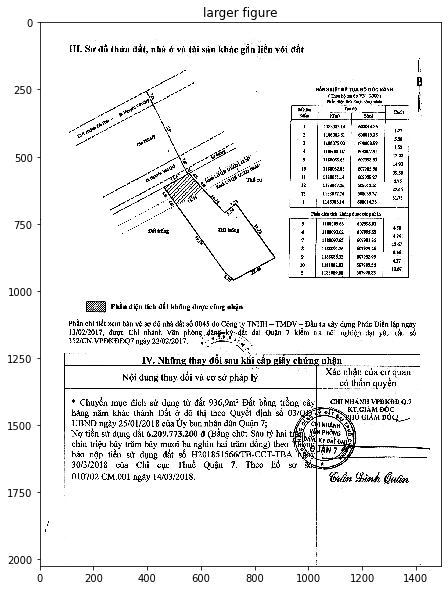

In [ ]:
image_path = './imgtxtenh/pre_test13.jpg'
image = imgproc.loadImage(image_path)

fig2 = plt.figure(figsize = (10,10)) # create a 10 x 10 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(image, interpolation='none')
ax3.set_title('larger figure')
plt.show()

In [ ]:
listText = img_to_text(image)
print(listText)
listX, listY = X_Y_localization(listText)
print(listX, listY)
X,Y = norm_X_Y(listX,listY)
print(X,Y)
print(get_X_Y(X,Y))

['\x0c', 'dat,\n\x0c', 'gan\n\x0c', '\x0c', 'dat\n\x0c', '\x0c', 'So’\n\x0c', 'thira\n\x0c', '\x0c', 'i\n\x0c', '\x0c', '\x0c', '\x0c', '\x0c', 'VOl\n\x0c', 'BANG\n\x0c', '\x0c', 'TOA\n\x0c', '\x0c', 'GOC\n\x0c', '\x0c', '\x0c', '\x0c', '( Theo\n\x0c', 'né toa\n\x0c', 'ad\n\x0c', '\x0c', '\x0c', 'dita\n\x0c', 'tich\n\x0c', '\x0c', '\x0c', '\x0c', 'Toa\n\x0c', 'ag\n\x0c', '06 hiéy\n\x0c', '\x0c', '\x0c', '\x0c', 'X(m)\n\x0c', '\x0c', '\x0c', '1188083,14\n\x0c', '608014.36\n\x0c', '\x0c', '1188082.6)\n\x0c', '\x0c', '\x0c', '\x0c', '\x0c', '5.58\n\x0c', '4188079.\n\x0c', '\x0c', '608008.\n\x0c', '\x0c', '1.52\n\x0c', '88080.07\n\x0c', '608007.91\n\x0c', '13.22\n\x0c', '\x0c', '1188089.68\n\x0c', '607998.83\n\x0c', '14.93\n\x0c', '\x0c', 'a\n?\n\nwoe 4 yor\n\nue pAss\n\nof f\n\x0c', '1188082.83\n\x0c', '607985.56\n\x0c', '* S. a\nal\n\x0c', '\x0c', '39.58\n\x0c', '\x0c', '1188051.14\n\x0c', '\x0c', '\x0c', 'Tho.\n\x0c', '\x0c', '3.75\n\x0c', '1188047,26\n\x0c', '608013.51\n\x0c', '22.46\n